In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
m_sqrt_error = mean_squared_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm_notebook

from itertools import product
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('UnemploymentRateJan1986-Dec2018.csv')
data.head()

,Months,Unemployment_Rates
0,Jan-86,8.53
1,Feb-86,8.92
2,Mar-86,8.48
3,Apr-86,8.06
4,May-86,7.71


In [3]:
data.describe()

,Unemployment_Rates
count,396.000000
mean,6.726212
std,1.811832
min,3.930000
25%,5.410000
50%,6.210000
75%,7.947500
max,11.990000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 2 columns):
Months                396 non-null object
Unemployment_Rates    396 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [5]:
data.isnull().count()

Months                396
Unemployment_Rates    396
dtype: int64

In [6]:
data['Months']=pd.to_datetime(data['Months'],format='%b-%y', errors='coerce')
data.set_index('Months', inplace=True)
ts = data['Unemployment_Rates']

Text(0, 0.5, 'Unemployment Rates')

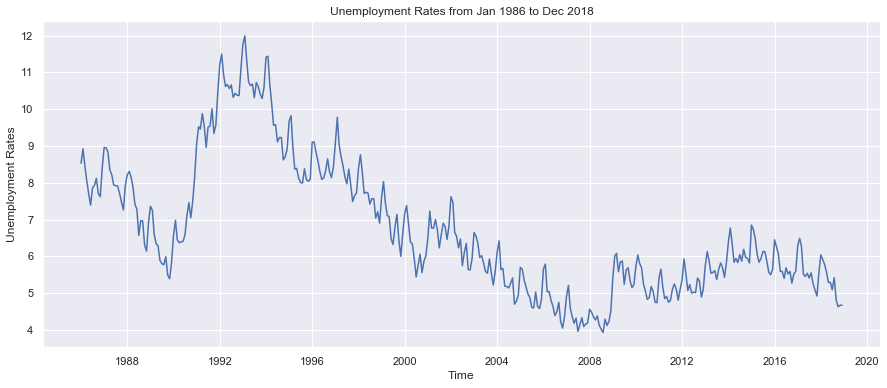

In [7]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

plt.figure()
plt.plot(ts)
plt.title('Unemployment Rates from Jan 1986 to Dec 2018')
plt.xlabel('Time')
plt.ylabel('Unemployment Rates')

In [8]:
# Train-Test Split

test_size = 12
train_size = len(data) - test_size

train = data[:train_size]
test = data[-test_size:]

<Figure size 1080x432 with 0 Axes>

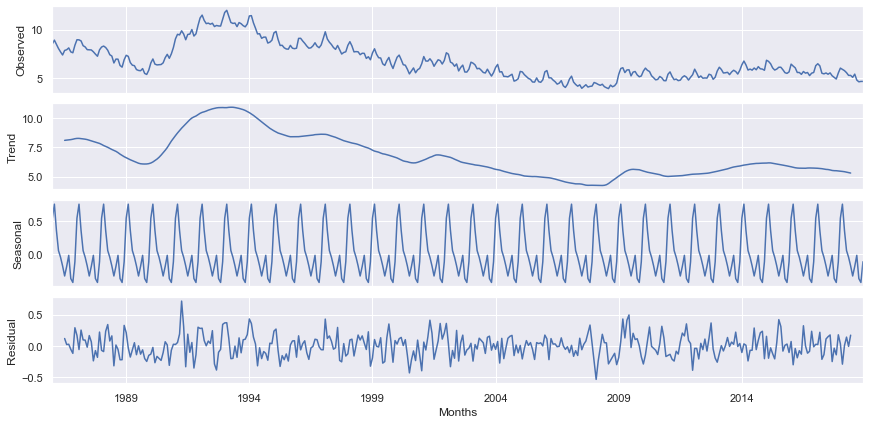

In [9]:
decomposition = seasonal_decompose(ts, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6);

In [10]:
# MA-12 is the most smooth line!
# decomposition -----------------> additive or multplicative?
# Have seasonalty! --> SARIMA

In [11]:
# SARIMA

# order selection

# Assumption: ARMA should satisfy weak stationarity (mean & variance)
# EDA shows that the mean is not stationary and the variance is unsure.

# Additive method: constant magnitude --> constant variance
# Multiplicative method: cumulative magnitude --> inconstant variance --> log transform

# Additive and Multiplicative have very close result. 
# Assume constant variance, so only focus on mean stationarity

## Check stationarity

<Figure size 1080x432 with 0 Axes>

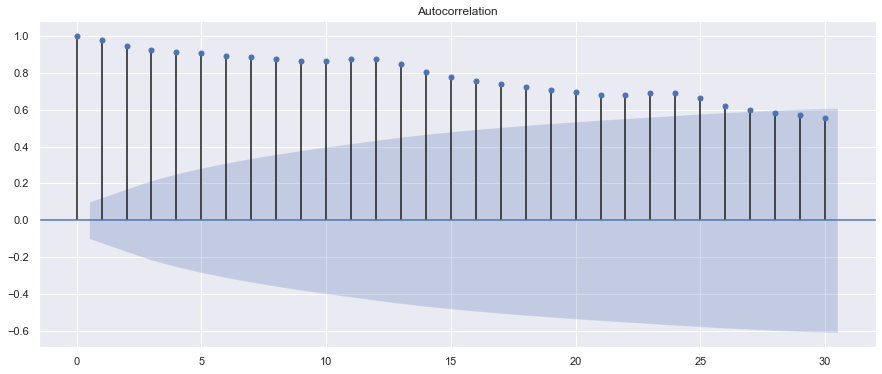

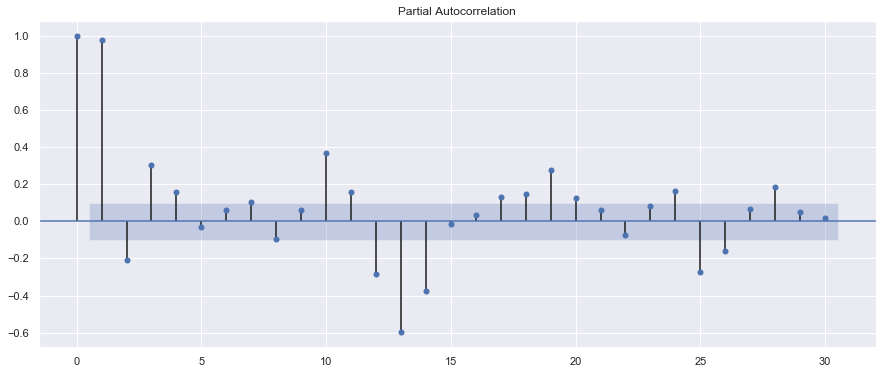

In [12]:
plt.figure()
smt.graphics.plot_acf(train, lags=30, alpha = 0.05)
smt.graphics.plot_pacf(train, lags=30, alpha = 0.05)
plt.show()

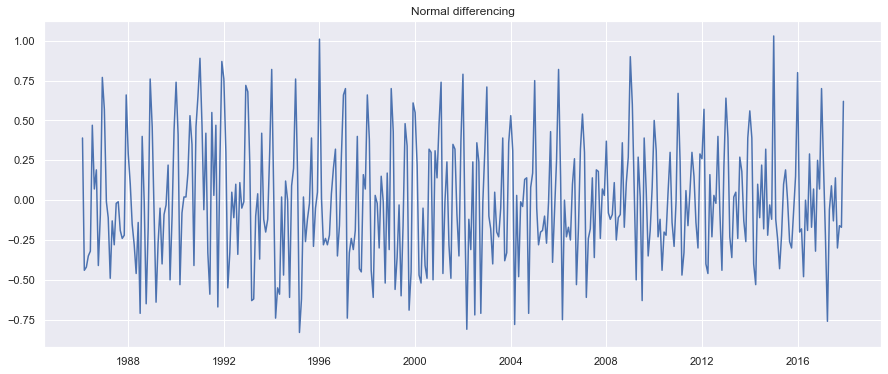

In [13]:
# ACF - mean is non-stationary
# check the differenced data
# after normal differencing(d=1), the data become more constant in mean

train_diff_normal = train.diff()[1:]
plt.figure()
plt.plot(train_diff_normal)
plt.title('Normal differencing')
plt.show()

In [14]:
# Mean looks stationary,check ACF and PACF

<Figure size 1080x432 with 0 Axes>

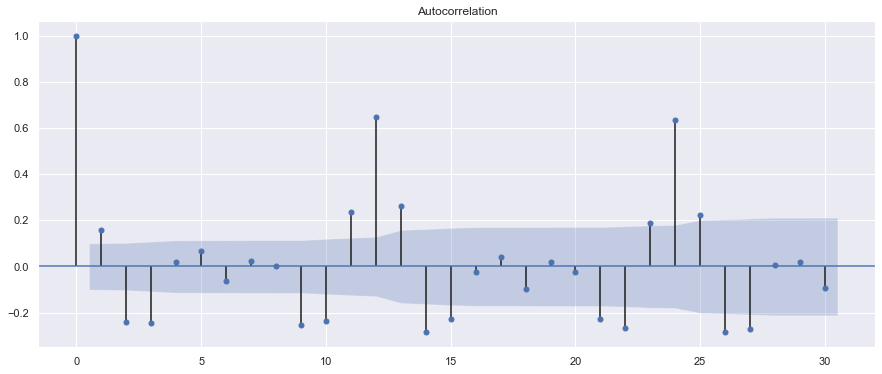

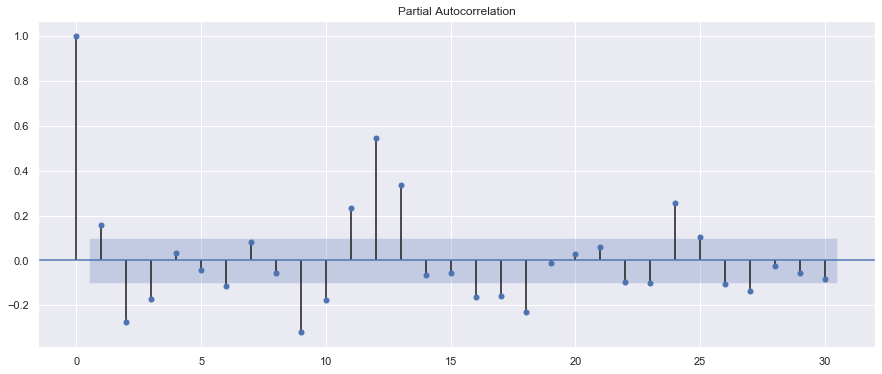

In [15]:
plt.figure()
smt.graphics.plot_acf(train_diff_normal, lags=30, alpha = 0.05)
smt.graphics.plot_pacf(train_diff_normal, lags=30, alpha = 0.05)
plt.show()

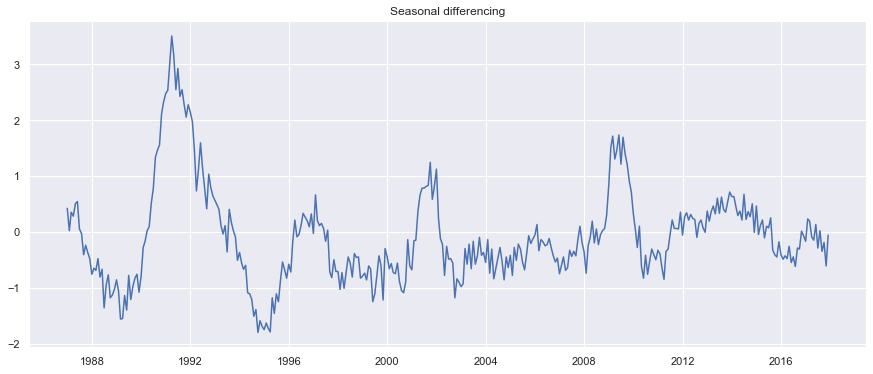

In [16]:
# Still not stationary, try seasonal differencing (D=1)

train_diff_seasonal = train.diff(12)[12:]

plt.figure()
plt.plot(train_diff_seasonal)
plt.title('Seasonal differencing')
plt.show()

In [17]:
# Mean looks non-stationary,check the ACF and PACF

<Figure size 1080x432 with 0 Axes>

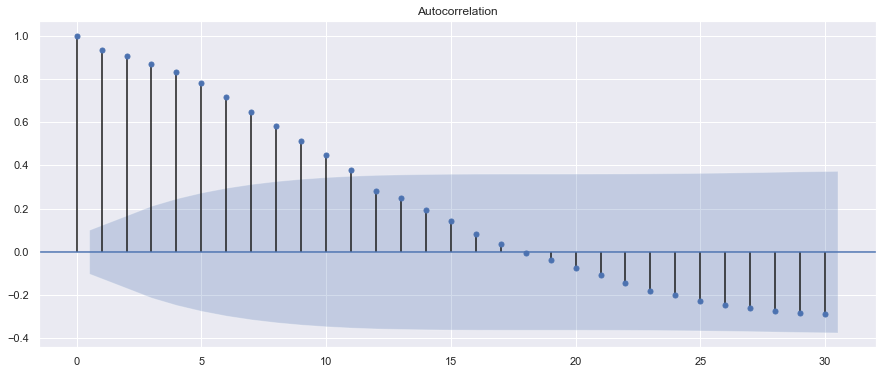

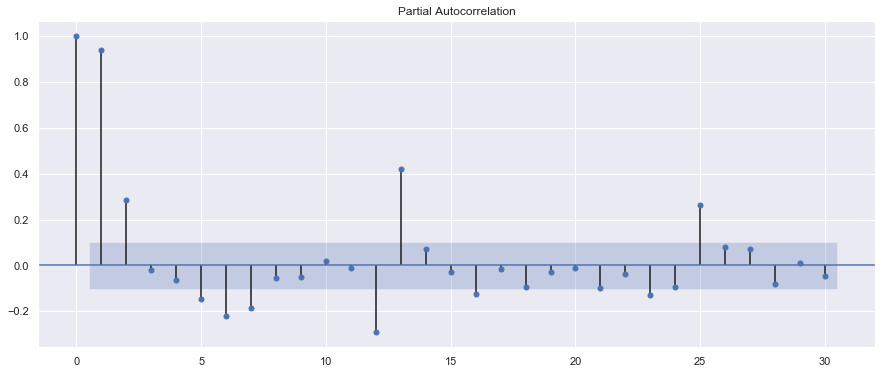

In [18]:
plt.figure()
smt.graphics.plot_acf(train_diff_seasonal, lags=30, alpha = 0.05)
smt.graphics.plot_pacf(train_diff_seasonal, lags=30, alpha = 0.05)
plt.show()

In [19]:
# Try seasonal and normal difference (D=1, d=1)

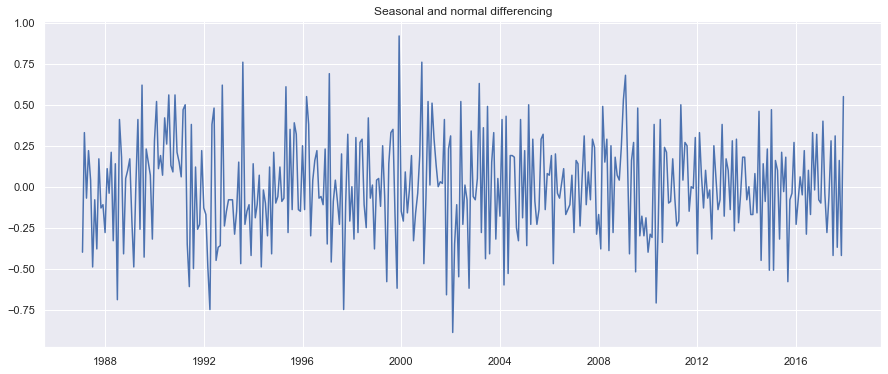

In [20]:
train_diff_ns = train_diff_seasonal.diff()[1:]
plt.figure()
plt.plot(train_diff_ns)
plt.title('Seasonal and normal differencing')
plt.show()

In [21]:
# Mean looks stationary, check ACF and PACF

<Figure size 1080x432 with 0 Axes>

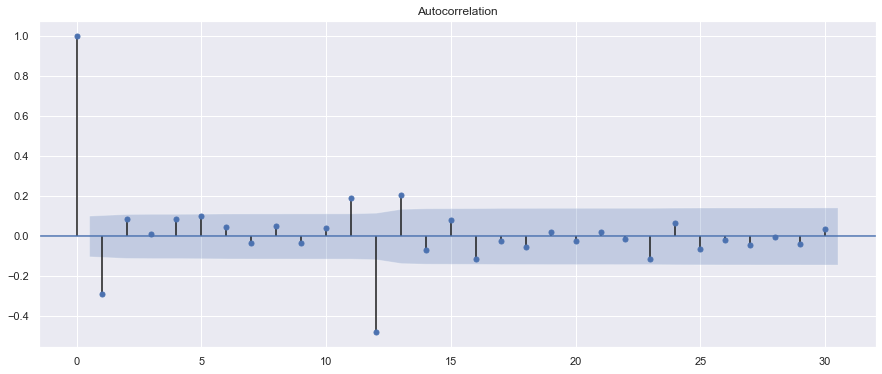

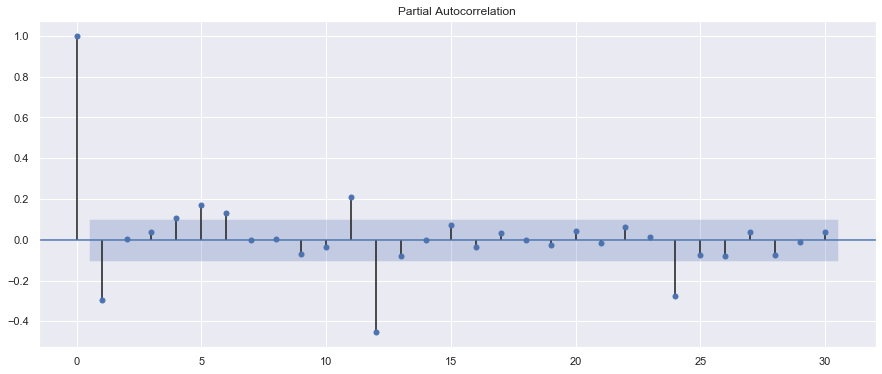

In [22]:
plt.figure()
smt.graphics.plot_acf(train_diff_ns, lags=30, alpha = 0.05)
smt.graphics.plot_pacf(train_diff_ns, lags=30, alpha = 0.05)
plt.show()

In [23]:
# ACF shows that the mean is seasonally stationary since the autocorrelation decreased very fast.
# ACF for MA(q,Q) 
# --> q = 1, 2, 4or 5
# --> Q = 1 
# PACF for AR(p,P)
# --> p =1, 4, 5, 6
# --> P is unsure --> should be 0 since it is decreasing slowly --> not exist P --> the rule is the cut off point
# d = 1 and D = 1 as shown above

In [24]:
# Other techniques: AIC BIC...

SARIMA (p,d,q) (P,D,Q) --> SARIMA (1,1,1)(0,1,1)...

## Model fitting and residual diagnostics

In [25]:
#Model fitting

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train, order=(1,1,1),             
                seasonal_order=(0,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False) 

sarima_model_fit = sarima_model.fit(disp = -1)

In [26]:
print(sarima_model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                 Unemployment_Rates   No. Observations:                  384
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                   4.188
Date:                            Wed, 27 May 2020   AIC                             -0.377
Time:                                    16:36:42   BIC                             15.134
Sample:                                01-01-1986   HQIC                             5.793
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1916      0.237     -0.808      0.419      -0.657       0.273
ma.L1         -0.0230      0.235   

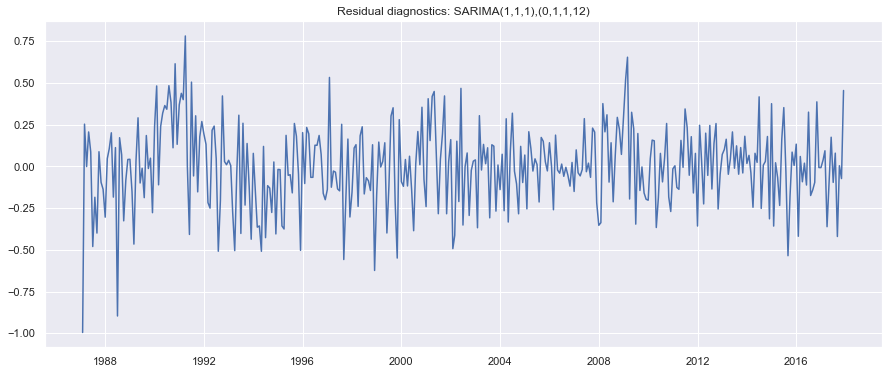

In [27]:
residuals_sarima = pd.DataFrame(sarima_model_fit.resid)[13:]

plt.figure()
plt.plot(pd.DataFrame(residuals_sarima))
plt.title("Residual diagnostics: SARIMA(1,1,1),(0,1,1,12)")
plt.show()

<Figure size 1080x432 with 0 Axes>

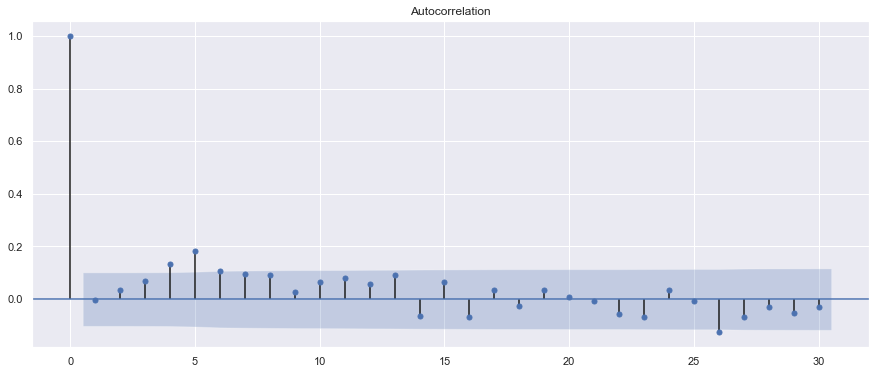

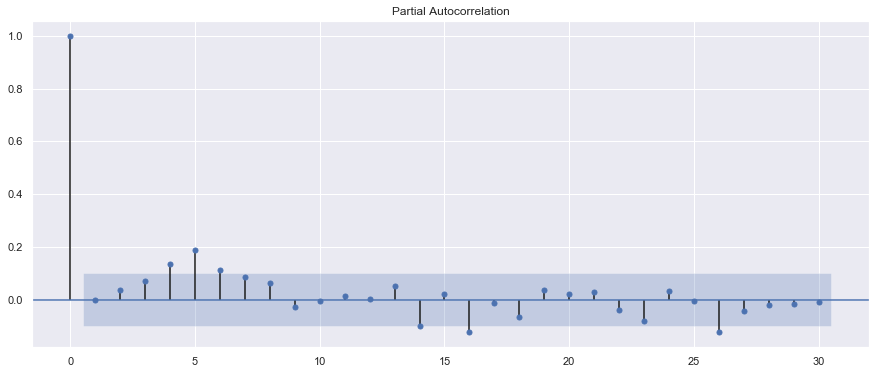

In [28]:
# the beginning part is violate significantly because differencing leads to missing values. 
# show the ACF and PACF for the residual --> showing a good result of the model fitting.

plt.figure()
smt.graphics.plot_acf(residuals_sarima, lags=30, alpha = 0.05)
smt.graphics.plot_pacf(residuals_sarima, lags=30, alpha = 0.05)
plt.show()

## Forecast

In [29]:
forecast_sarima = sarima_model_fit.forecast(len(test))
forecast_sarima

2018-01-01    6.129828
2018-02-01    6.320108
2018-03-01    6.026488
2018-04-01    5.576162
2018-05-01    5.534934
2018-06-01    5.477178
2018-07-01    5.456655
2018-08-01    5.509300
2018-09-01    5.569033
2018-10-01    5.328848
2018-11-01    5.233546
2018-12-01    5.467995
Freq: MS, dtype: float64

Text(0, 0.5, 'Unemplotment Rates')

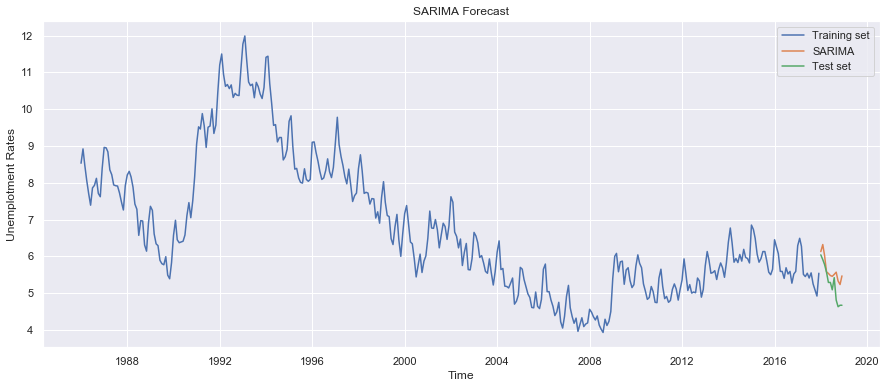

In [30]:
plt.figure()
plt.plot(train,label = 'Training set')
plt.plot(test.index, pd.DataFrame(forecast_sarima),label = 'SARIMA')
plt.plot(test,label = 'Test set')
plt.legend()
plt.title('SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Unemplotment Rates')

In [31]:
# MSE for SARIMA

sarima_pred = forecast_sarima
sarima_true = test
mean_squared_error(sarima_true, sarima_pred)

0.20778263927108243

## Best practice --- SARIMA (5,1,2)(0,1,2,12)

In [32]:
sarima_optimal = SARIMAX(train, order=(5,1,2),             
                seasonal_order=(0,1,2,12),
                enforce_stationarity=False,
                enforce_invertibility=False) 

sarima_optimal_fit = sarima_optimal.fit(disp = -1)

In [33]:
forecast_sarima_optimal = sarima_optimal_fit.forecast(len(test))
forecast_sarima_optimal

2018-01-01    5.977619
2018-02-01    6.217154
2018-03-01    5.861335
2018-04-01    5.487183
2018-05-01    5.398710
2018-06-01    5.378702
2018-07-01    5.316890
2018-08-01    5.407863
2018-09-01    5.435276
2018-10-01    5.214025
2018-11-01    5.099198
2018-12-01    5.373591
Freq: MS, dtype: float64

Text(0, 0.5, 'Unemplotment Rates')

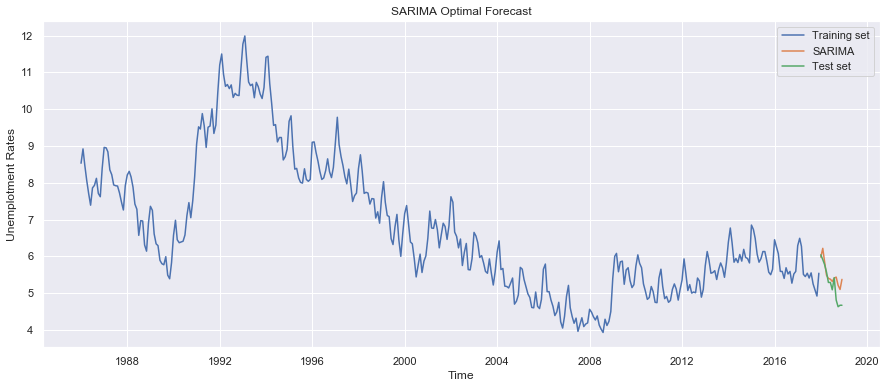

In [34]:
plt.figure()
plt.plot(train,label = 'Training set')
plt.plot(test.index, pd.DataFrame(forecast_sarima_optimal),label = 'SARIMA')
plt.plot(test,label = 'Test set')
plt.legend()
plt.title('SARIMA Optimal Forecast')
plt.xlabel('Time')
plt.ylabel('Unemplotment Rates')

In [35]:
#MSE

sarima_pred_optimal = forecast_sarima_optimal
sarima_true = test
mean_squared_error(sarima_true, sarima_pred_optimal)

0.13286065255876064

## Test

In [36]:
sarima_test = SARIMAX(train, order=(5,1,2),             
                seasonal_order=(0,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False) 

sarima_test_fit = sarima_test.fit(disp = -1)

In [37]:
forecast_sarima_test = sarima_test_fit.forecast(len(test))
forecast_sarima_test

2018-01-01    6.019772
2018-02-01    6.188391
2018-03-01    5.894262
2018-04-01    5.473824
2018-05-01    5.442215
2018-06-01    5.369672
2018-07-01    5.382054
2018-08-01    5.416715
2018-09-01    5.487213
2018-10-01    5.235092
2018-11-01    5.161505
2018-12-01    5.387104
Freq: MS, dtype: float64

In [38]:
sarima_pred_test = forecast_sarima_test
sarima_true = test
mean_squared_error(sarima_true, sarima_pred_test)

0.14963399125169566